In [77]:
import copy
import os
import sys
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import torch
import yaml
from custom_dataset import collate_fn
from final_pipeline import ModelWrapper, get_data, get_loss_fn, set_seeds, setup_device
from full_pipeline import find_project_root
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from training import validation_loop
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

SEED = 42
QUICK_DEBUG = False
MEDIUM_DEBUG = True


def to_batch_major_order(batch) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Convert collate_fn output into (T, B, F) and mask (T, B).
    """
    xs, ys, mask = batch
    xs_t = xs.permute(1, 0, 2)  # (T, B, F)
    mask_t = mask.permute(1, 0)  # (T, B)
    return xs_t, mask_t


class ShapModel(nn.Module):
    def __init__(
        self,
        base_model,
        background_data,
        device,
        pad_value: float = 0.0,
    ):
        """
        Wrap model for SHAP compatibility.

        Args:
            base_model: Transformer model that expects (B, T, F) + mask
            pad_value: Value used to pad sequences (often 0)
        """
        super().__init__()
        self.device = device
        self.base = base_model
        self.pad_value = pad_value
        bg_loader = DataLoader(
            background_data.dataset,
            batch_size=min(100, len(background_data.dataset)),
            shuffle=False,
            generator=torch.Generator().manual_seed(SEED),
            collate_fn=collate_fn_wrapper,
            drop_last=False,
        )
        self.bg_batch = next(iter(bg_loader))
        self.bg_xs, self.bg_mask = to_batch_major_order(self.bg_batch)
        self.explainer = shap.GradientExplainer(self, self.bg_xs)

    def forward(self, xs):
        # xs comes in as (B, T, F)
        xs = xs.to(self.device)  # move to appropriate device

        # Reconstruct the mask: True for non-padding timesteps
        mask = xs.abs().sum(dim=-1) != (self.pad_value * xs.size(-1))
        mask = mask.transpose(0, 1)  # (B, T) -> (T, B)

        # Transpose into (T, B, F) for transformer
        xs_t = xs.transpose(0, 1)

        logits = self.base(xs_t, mask=mask)  # returns (B,) or (B,1)

        # Ensure SHAP always sees a 2D output
        if logits.dim() == 1:
            logits = logits.unsqueeze(-1)  # (B,1)

        return logits

    def get_shap_values(self, data):
        loader = DataLoader(
            data.dataset,
            batch_size=64,
            shuffle=False,
            collate_fn=collate_fn_wrapper,
            drop_last=False,
        )
        shap_vals = []
        masks = []

        # change this to loop through batches with tqdm
        i = 0
        for batch in tqdm(loader):
            xs, mask = to_batch_major_order(batch)
            shap_vals.append(self.explainer.shap_values(xs))
            masks.append(mask.cpu().numpy())
            if QUICK_DEBUG:
                break
            if MEDIUM_DEBUG:
                i += 1
                if i >= 2:
                    break
        shap_vals = np.concatenate(shap_vals, axis=0)
        shap_vals = np.squeeze(shap_vals, -1)
        masks = np.concatenate(masks, axis=0)
        # Broadcast mask to SHAP values without transposing to ensure matching dimensions
        # shap_vals shape: (B, T, F), mask shape: (B, T)
        shap_vals = shap_vals * masks[:, :, np.newaxis]

        return shap_vals


def get_config(root, folder_name):
    config_path = f"{root}/models/model_B/results/{folder_name}/xperiment.yml"
    if not os.path.isfile(config_path):
        raise FileNotFoundError(f"Config file does not exist: {config_path}")
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config


# --------------------------------------------------------------------------
# Helper to compute predictions, ground-truth labels, and patient IDs
# --------------------------------------------------------------------------


def get_patient_predictions(model_wrapper, data, device, pred_threshold):
    """Return lists of patient IDs, y_true, and predicted probabilities.

    The order matches the dataset order (shuffle=False).
    """

    from torch.utils.data import DataLoader  # local import to avoid polluting namespace

    loader = DataLoader(
        data.dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=collate_fn_wrapper,
        drop_last=False,
    )

    patient_ids = data.dataset.unique_patient_ids

    # patient_ids = unscale_patient_ids(patient_ids)
    y_trues = []
    y_probs = []
    y_preds = []

    model = model_wrapper.model  # underlying TransformerTimeSeries
    model.eval()

    with torch.no_grad():
        for xs, ys, mask in loader:
            xs = xs.to(device)
            ys = ys.to(device)
            mask = mask.to(device)

            logits = model(xs, mask=mask)  # (B, 1) or (B,)
            probs = torch.sigmoid(logits.squeeze(-1))
            preds = (probs >= pred_threshold).type(torch.int32).cpu().numpy()
            y_trues.extend(ys.cpu().numpy())
            y_preds.extend(preds)
            y_probs.extend(probs.cpu().numpy())

    return patient_ids, np.array(y_trues), np.array(y_preds), np.array(y_probs)


def collate_fn_wrapper(batch):
    """Wrapper for the collate function with fixed max_len."""
    return collate_fn(batch, max_len=400)


def prepare_shap_values(explainer, test_xs, test_mask) -> np.ndarray:
    """Prepare and process SHAP values with proper masking."""
    # Calculate SHAP values
    sh_vals = explainer.shap_values(test_xs)

    # Convert (N, T, F, 1) → (N, T, F)
    shap_vals = np.squeeze(sh_vals, -1)

    # Convert test_mask to (B, T, 1) for broadcasting
    test_mask_np = test_mask.cpu().numpy()[:, :, np.newaxis]  # (B, T, 1)

    # Apply mask - multiply SHAP values by mask (1 for real data, 0 for padding)
    return shap_vals * test_mask_np



def plot_global_feature_importance(abs_vals, feature_names) -> None:
    """
    Bar plot of mean |SHAP| for each feature aggregated over patients & time.

    Args:
        abs_vals: Absolute SHAP values
        feature_names: List of feature names
    """
    global_imp = abs_vals.mean(axis=(0, 1))  # (F,)
    order = np.argsort(-global_imp)  # descending

    plt.figure(figsize=(8, 10))
    plt.barh(np.array(feature_names)[order], global_imp[order])
    plt.gca().invert_yaxis()
    plt.title("Mean |SHAP| per feature (all patients, all timesteps)")
    plt.xlabel("Mean |SHAP value|")
    plt.tight_layout()
    plt.show()


def plot_temporal_importance(abs_vals, time_index) -> None:
    """
    Line plot of mean |SHAP| at each time-step (aggregated over patients & features).

    Args:
        abs_vals: Absolute SHAP values
        time_index: Array of time indices
    """
    time_imp = abs_vals.mean(axis=(0, 2))  # (T,)
    plt.figure(figsize=(12, 4))
    plt.plot(time_index, time_imp)
    plt.title("Mean |SHAP| across time (all patients, all features)")
    plt.xlabel("ICU LOS (hours)")
    plt.ylabel("Mean |SHAP value|")
    plt.tight_layout()
    plt.show()


def beeswarm_collapsed_over_time(shap_vals, feature_names) -> None:
    """
    Classic SHAP 'beeswarm' after collapsing each patient-feature pair
    to the timestep with the largest absolute SHAP value, while keeping
    the original sign.

    Args:
        shap_vals: SHAP values array
        feature_names: List of feature names
    """
    # Index of the timestep where |SHAP| is largest for every patient-feature
    idx_max = np.abs(shap_vals).argmax(axis=1)  # shape (N, F)

    # Gather the signed SHAP value at that timestep
    collapse = shap_vals[
        np.arange(shap_vals.shape[0])[:, None],  # patient axis
        idx_max,
        np.arange(shap_vals.shape[2]),  # feature axis
    ]  # resulting shape (N, F)

    shap.summary_plot(
        collapse,
        features=None,
        feature_names=feature_names,
        show=True,
    )


def get_pred_threshold(model, val_data, device, config):
    """Get the prediction threshold for the given model."""
    val_loader = DataLoader(
        val_data.dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=collate_fn_wrapper,
        drop_last=False,
    )
    loss_fn = get_loss_fn(config, val_data, device)
    (
        val_loss,
        val_acc,
        val_prec,
        val_rec,
        f2_score,
        full_y_pred,
        full_y_true,
        best_thr,
    ) = validation_loop(model.model, val_loader, loss_fn, device)
    return best_thr




In [12]:
set_seeds()

In [ ]:
project_root = find_project_root()
results_name = "medium_model_no_sampling"
config = get_config(project_root, results_name)

device = setup_device()
train_data = get_data(config, "train")
val_data = get_data(config, "val")

test_data = get_data(config, "test")
in_dim = train_data.X.shape[1]

model = ModelWrapper(config, device, in_dim)
model.load_saved_weights()

shap_model = ShapModel(model.model, train_data, device, pad_value=0.0)
shap_vals = shap_model.get_shap_values(test_data)  # (64, 400, 107)
# print shape of shap_vals
print("shap_vals shape: ", shap_vals.shape)

# Get feature names early so they can be used throughout
feature_names = train_data.X.columns.tolist()  # list of feature names

pred_threshold = get_pred_threshold(model, val_data, device, config)
print(f"Prediction threshold: {pred_threshold}")

time_index = np.arange(shap_vals.shape[1])

# Calculate global importance for other visualizations but not for patient heatmaps
abs_vals = np.abs(shap_vals)
top_10_features = np.argsort(-abs_vals.mean(axis=(0, 1)))[:10]
top_10_feature_names = np.array(feature_names)[top_10_features]
top_10_abs_vals = np.abs(shap_vals[:, :, top_10_features])

patient_ids, y_trues, y_preds, y_probs = get_patient_predictions(
    model, test_data, device, pred_threshold
)

Using MPS device


/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower th

shap_vals shape:  (128, 400, 107)
Pos weight: 12.77
Prediction threshold: 0.9500000000000001


In [41]:
def remove_padding(patient_data):
    non_zero_timesteps = np.where(~(patient_data == 0).all(axis=1))[0]

    if len(non_zero_timesteps) > 0:
        last_timestep = non_zero_timesteps[-1] + 1
        valid_time_index = time_index[:last_timestep]
        valid_patient_data = patient_data[:last_timestep]
    else:
        valid_time_index, valid_patient_data = time_index, patient_data
    return valid_time_index, valid_patient_data


In [34]:

# --- Visualization functions ---
def patient_heatmap(
    shap_vals,
    feature_names,
    time_index,
    idx: int,
    patient_id: str,
    y_true: float,
    y_pred: float,
    y_prob: float,
    only_target_relevant: bool = True,
) -> None:
    """
    Heat-map of SHAP values across time (x) and features (y) for one patient.

    Args:
        shap_vals: SHAP values array
        feature_names: List of feature names
        time_index: Array of time indices
        idx: Patient index to visualize
        patient_id: ID of the patient
        y_true: True label
        y_pred: Predicted label
        y_prob: Prediction probability
        only_target_relevant: If True, only show SHAP values relevant to target class
    """
    # Get and truncate patient data to non-zero timesteps
    patient_data = copy.deepcopy(shap_vals[idx])  # shape (T, F)
    non_zero_timesteps = np.where(~(patient_data == 0).all(axis=1))[0]

    valid_time_index, valid_patient_data = remove_padding(patient_data)

    # Filter values based on true label if requested
    if only_target_relevant:
        valid_patient_data = np.clip(
            valid_patient_data,
            a_min=0 if y_true == 1 else None,
            a_max=0 if y_true == 0 else None,
        )

    # Identify top features for this patient
    mean_shap_importance = np.abs(valid_patient_data).mean(axis=0)
    top_features = np.argsort(mean_shap_importance)[-10:]
    top_feature_names = np.array(feature_names)[top_features]

    # Create heatmap
    plt.figure(figsize=(max(10, valid_time_index.shape[0] * 0.1), 8))
    sns.heatmap(
        valid_patient_data[:, top_features].T,
        cmap="vlag",
        center=0,
        yticklabels=top_feature_names,
        xticklabels=valid_time_index,
    )
    plt.title(
        f"Patient {patient_id}  |  y_true={int(y_true)}  |  y_pred={int(y_pred)}  |  y_prob={y_prob:.2f}",
        fontsize=14,
    )
    plt.xlabel("ICU LOS (hours)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()



In [33]:

def global_heatmap(
    shap_vals,
    feature_names,
    time_index,
    target: int,
    y_preds,
    only_target_relevant: bool = True,
    window_size: int = 30,
) -> None:
    """
    Global heat-map of SHAP values across time (x) and features (y) for all patients
    predicted as the target class.

    Args:
        shap_vals: SHAP values array
        feature_names: List of feature names
        time_index: Array of time indices
        target: Target class (0 or 1)
        y_preds: Predicted labels for each patient
        only_target_relevant: If True, only show SHAP values relevant to target class
    """
    # Make sure we only use indices that exist in shap_vals
    max_idx = len(shap_vals) - 1

    # Filter to patients where model predicted the target class
    # Limit to indices that are available in shap_vals
    target_indices = np.where(y_preds == target)[0]
    target_indices = target_indices[target_indices <= max_idx]

    if len(target_indices) == 0:
        print(f"No patients were predicted as class {target}")
        return

    # Extract and aggregate SHAP values for target class patients
    target_shap_vals = copy.deepcopy(shap_vals[target_indices])


    # Filter values based on target class if requested
    if only_target_relevant:
        target_shap_vals = np.clip(
            target_shap_vals,
            a_min=0 if target == 1 else None,
            a_max=0 if target == 0 else None,
        )

    # Aggregate across patients
    mean_shap_vals = target_shap_vals.mean(axis=0)  # (T, F)

    # ------------------------------------------------------------------
    # Select the most important contiguous window of timesteps
    # ------------------------------------------------------------------

    # Compute importance per timestep (aggregate over features via mean |SHAP|)
    time_importance = np.abs(mean_shap_vals).mean(axis=1)  # shape (T,)

    if len(time_importance) <= window_size:
        window_start, window_end = 0, len(time_importance)
    else:
        # Use convolution to compute summed importance for every contiguous window
        window_scores = np.convolve(
            time_importance, np.ones(window_size, dtype=float), mode="valid"
        )
        window_start = int(window_scores.argmax())
        window_end = window_start + window_size

    # Restrict data to the selected window
    window_time_index = time_index[window_start:window_end]
    window_shap_vals = mean_shap_vals[window_start:window_end, :]
    
    # print the window start and end
    print(f"Window start: {window_start}, Window end: {window_end}")

    # Identify top features within the selected window
    mean_importance = np.abs(window_shap_vals).mean(axis=0)
    top_features = np.argsort(-mean_importance)[:15]
    top_feature_names = np.array(feature_names)[top_features]

    # Plot heatmap for the selected window
    plt.figure(figsize=(max(10, len(window_time_index) * 0.1), 8))
    sns.heatmap(
        window_shap_vals[:, top_features].T,
        cmap="vlag",
        center=0,
        yticklabels=top_feature_names,
        xticklabels=window_time_index,
    )
    plt.title(
        f"Global SHAP Values for Class {target} (Top {window_size}-hr Window, n={len(target_indices)})",
        fontsize=14,
    )
    plt.xlabel("ICU LOS (hours)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------------
    # End sliding window selection
    # ------------------------------------------------------------------


In [ ]:
i = 0
for idx, (patient_id, y_true, y_pred, y_prob) in enumerate(
    zip(patient_ids, y_trues, y_preds, y_probs)
):
    patient_heatmap(
        shap_vals,  # Pass full SHAP values array
        feature_names,  # Pass all feature names
        time_index,
        idx,
        patient_id,
        y_true,
        y_pred,
        y_prob,
    )
    i += 1
    if i > 10:
        break

Window start: 0, Window end: 20


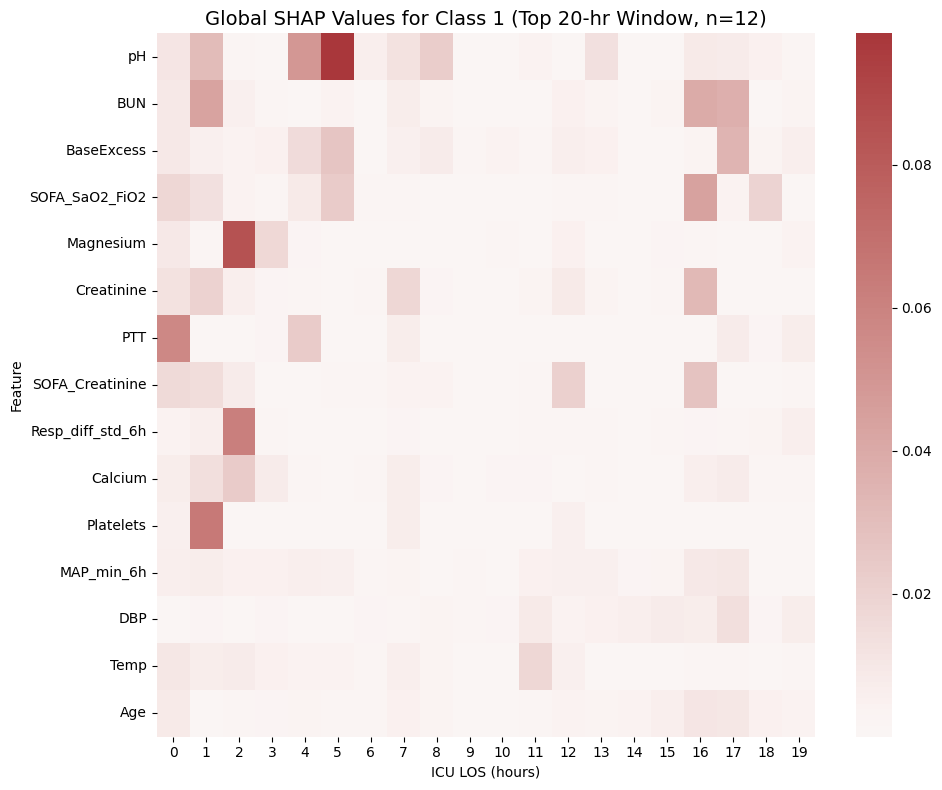

In [35]:
global_heatmap(shap_vals, feature_names, time_index, 1, y_preds, window_size=20)

Window start: 0, Window end: 20


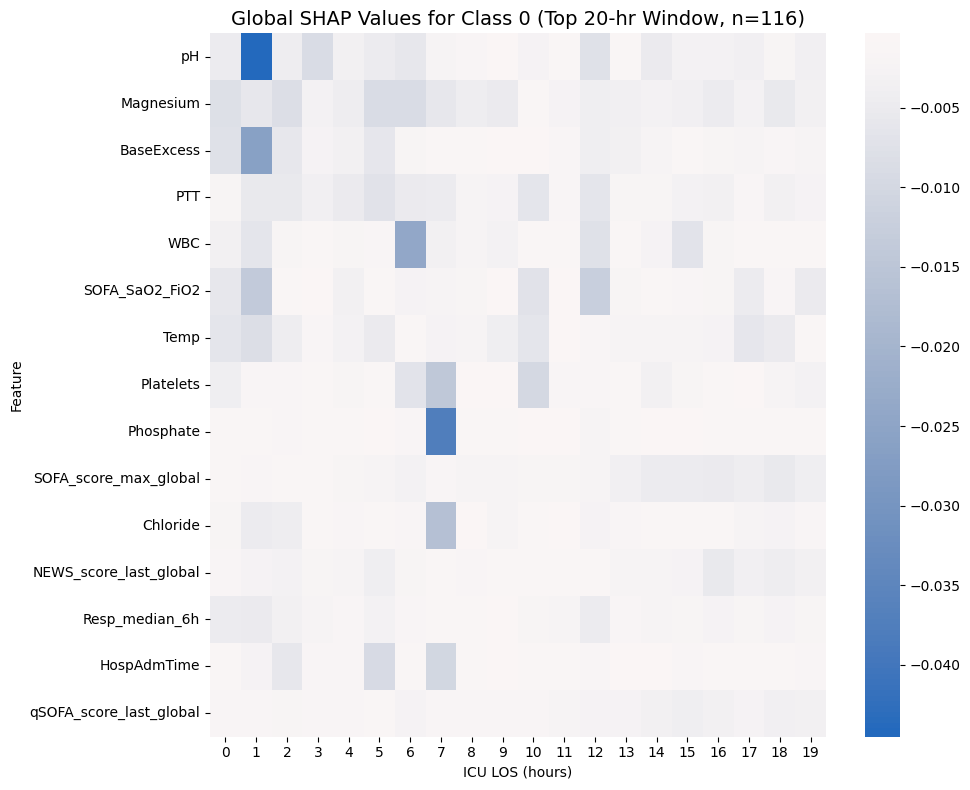

In [36]:
global_heatmap(shap_vals, feature_names, time_index, 0, y_preds, window_size=20)

In [81]:
def global_importance_plot(shap_vals, feature_names, time_index, target, y_preds):
    """
    Plot the global importance of each feature for the target class.
    """
    # Filter to patients where model predicted the target class
    max_idx = len(shap_vals) - 1
    target_indices = np.where(y_preds == target)[0]
    target_indices = target_indices[target_indices <= max_idx]
    target_shap_vals = copy.deepcopy(shap_vals[target_indices])
    
    
    target_shap_vals = np.clip(
        target_shap_vals,
        a_min=0 if target == 1 else None,
        a_max=0 if target == 0 else None,
    )
    
    print(max(target_indices))
    # print the indices of target_shap_vals
    print(type(target_shap_vals))
    print(target_shap_vals.shape)
    
    # feature averages (F)
    feature_averages = []
    for i in range(len(target_shap_vals)):
        valid_time_index, valid_patient_data = remove_padding(target_shap_vals[i])
        average_feature_importance = valid_patient_data.mean(axis=0)
        feature_averages.append(average_feature_importance)
        
    global_feature_importance = np.array(feature_averages).mean(axis=0)
    
    # select top 10 features in ascending order
    top_features = np.argsort(np.abs(global_feature_importance))[-10:]
    top_feature_names = np.array(feature_names)[top_features]


    # plot the top 10 features
    plt.figure(figsize=(10, 8))

    # Choose a color based on target
    if target == 1:
        cmap = cm.get_cmap('coolwarm')  # red to blue, red is for high values
        color = cmap(0.9)  # closer to red
    else:
        cmap = cm.get_cmap('coolwarm')
        color = cmap(0.1)  # closer to blue

    # Plot the bar chart with color
    plt.barh(top_feature_names, global_feature_importance[top_features], color=color)

    plt.title(f"Global Feature Importance for Class {target}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

120
<class 'numpy.ndarray'>
(12, 400, 107)


/var/folders/s0/ldb10jg949ndmfwfkbsz5x480000gn/T/ipykernel_50083/1527200596.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # red to blue, red is for high values


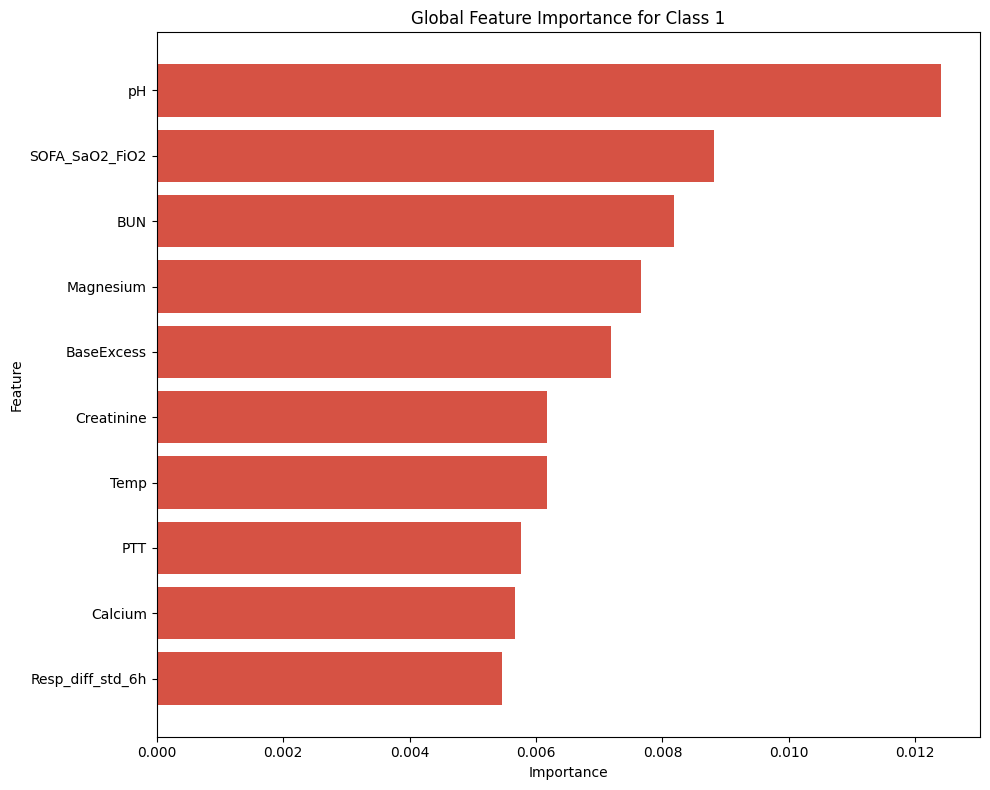

In [82]:
global_importance_plot(shap_vals, feature_names, time_index, 1, y_preds)

127
<class 'numpy.ndarray'>
(116, 400, 107)


/var/folders/s0/ldb10jg949ndmfwfkbsz5x480000gn/T/ipykernel_50083/1527200596.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


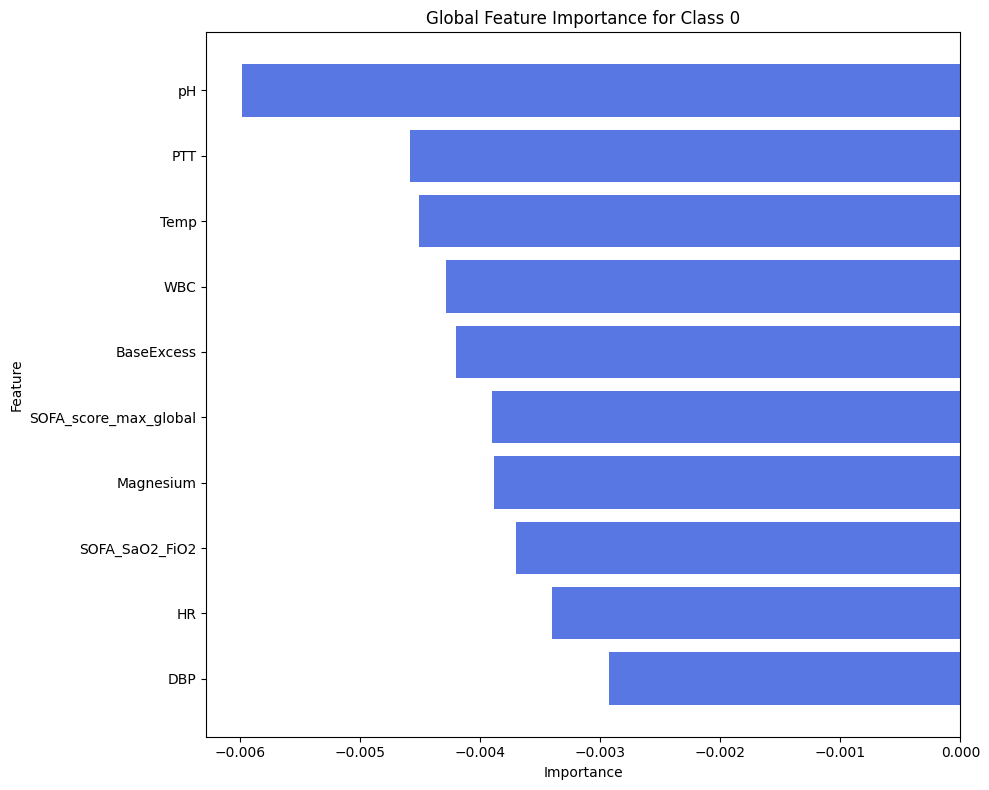

In [83]:
global_importance_plot(shap_vals, feature_names, time_index, 0, y_preds)

In [84]:
def overall_importance_plot(shap_vals, feature_names, time_index):
    """
    Plot the overall importance of each feature.
    """
    # feature averages (F)
    shap_vals = copy.deepcopy(shap_vals)
    shap_vals = np.abs(shap_vals)
    
    feature_averages = []   
    for i in range(len(shap_vals)):
        valid_time_index, valid_patient_data = remove_padding(shap_vals[i])
        average_feature_importance = valid_patient_data.mean(axis=0)
        feature_averages.append(average_feature_importance)
        
    global_feature_importance = np.array(feature_averages).mean(axis=0)
    
    # select top 10 features in ascending order
    top_features = np.argsort(np.abs(global_feature_importance))[-10:]
    top_feature_names = np.array(feature_names)[top_features]
    
    # plot the top 10 features
    plt.figure(figsize=(10, 8))
    plt.barh(top_feature_names, global_feature_importance[top_features])
    plt.title("Global Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")

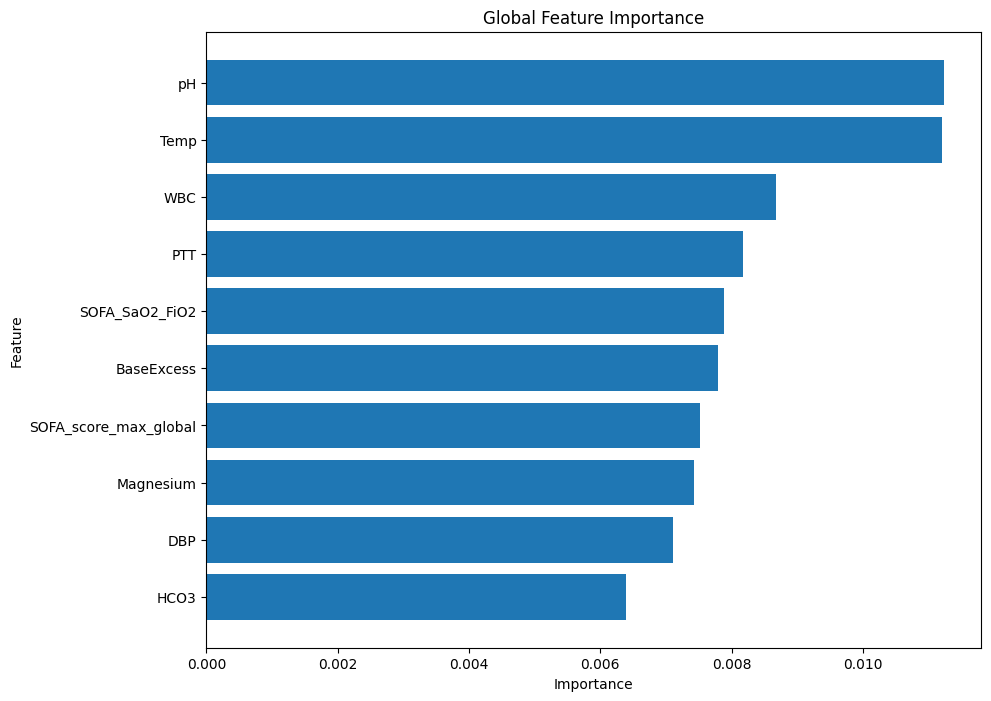

In [85]:
overall_importance_plot(shap_vals, feature_names, time_index)